# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [8]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [9]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']
pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,564.8391,0.2852,-47.1190
TRXUSDT,79.6748,73.2451,0.0370,-6.4297
JASMYUSDT,453.8661,296.7953,0.1498,-157.0707
SOLUSDT,261.7091,271.5565,0.1371,9.8474
OMUSDT,535.6761,548.7187,0.2770,13.0425
ETHUSDT,264.2048,181.6023,0.0917,-82.6025
BBUSDT,46.3321,43.0609,0.0217,-3.2712
BNBUSDT,1.1490,1.0169,0.0005,-0.1322
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Total,2254.5699,1980.8347,1.0000,-273.7352


In [10]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [11]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [12]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [13]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [14]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [15]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [16]:
positions=positions.sort_index()

In [17]:
positions.index=pd.to_datetime(positions.index)

In [18]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [19]:
positions.to_excel('Positions.xlsx')

In [20]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [21]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [22]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [23]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [24]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [25]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [26]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

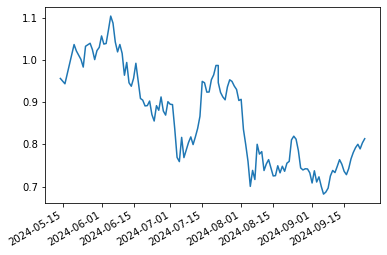

In [27]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [28]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [29]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [30]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [31]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [32]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio")
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
USDCUSDT,0.9360
OMUSDT,0.0233
BNBUSDT,0.0210
TRXUSDT,0.0122
PEPEUSDT,0.0041
JASMYUSDT,0.0028
CKBUSDT,0.0007
BONKUSDT,0.0000
DOTUSDT,0.0000
ETCUSDT,0.0000


In [33]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.436345
BTCUSDT,0.400000
BNBUSDT,0.100539
PEPEUSDT,0.040648
JASMYUSDT,0.022468


In [34]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [35]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.736669
OMUSDT,0.263331


## Real Portfolio vs Optimal

In [36]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,564.839078,0.285152,0.000000,0.000000
OMUSDT,548.718658,0.277014,0.263331,0.013683
JASMYUSDT,296.795322,0.149834,0.000000,0.000000
SOLUSDT,271.556505,0.137092,0.000000,0.000000
ETHUSDT,181.602301,0.091680,0.000000,0.000000
TRXUSDT,73.245102,0.036977,0.736669,-0.699692
BBUSDT,43.060871,0.021739,0.000000,0.000000
BNBUSDT,1.016885,0.000513,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [37]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,564.839078,0.285152,0.400000,-0.114848
OMUSDT,548.718658,0.277014,0.436345,-0.159331
JASMYUSDT,296.795322,0.149834,0.022468,0.127365
SOLUSDT,271.556505,0.137092,0.000000,0.000000
ETHUSDT,181.602301,0.091680,0.000000,0.000000
TRXUSDT,73.245102,0.036977,0.000000,0.000000
BBUSDT,43.060871,0.021739,0.000000,0.000000
BNBUSDT,1.016885,0.000513,0.100539,-0.100026
PEPEUSDT,0.000002,0.000000,0.040648,-0.040648


# Risk Reward Analysis

In [38]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [39]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

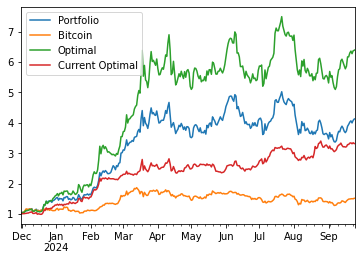

In [40]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [41]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

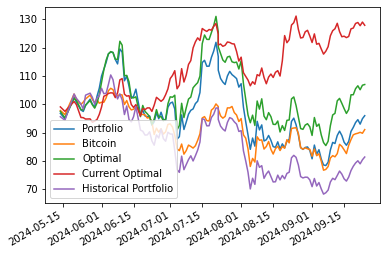

In [42]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [43]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-15,86.587017,83.895897,98.463802,124.053709,73.650513
2024-09-16,85.520527,82.583217,96.769384,123.553986,72.860240
2024-09-17,86.866792,85.509833,98.165790,123.967787,74.288060
2024-09-18,90.410279,87.535703,103.351879,126.653368,76.578064
2024-09-19,91.838387,89.203528,103.372302,126.933449,78.100735
2024-09-20,93.550667,89.561420,105.508594,128.560222,79.257782
2024-09-21,94.562914,89.770777,106.534840,128.893247,80.041385
2024-09-22,92.990673,90.095833,105.133536,127.765338,78.955810
2024-09-23,94.902564,89.756842,106.732961,129.048906,80.384976
2024-09-24,95.967916,91.054949,106.981170,127.912319,81.362290


## Volatilities

In [44]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.683762
dtype: float64

In [45]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.54969
dtype: float64

In [46]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.596257
Bitcoin            0.442476
Optimal            0.684874
Current Optimal    0.427257
dtype: float64

In [47]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.24610545729851008

## Risk Contribution

In [48]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.128098,0.100539,0.023209,0.033702,0.005223,0.028479
BTCUSDT,0.202471,0.400000,0.061157,0.167977,0.066785,0.101192
JASMYUSDT,0.032161,0.022468,0.005545,0.013676,0.001273,0.012404
OMUSDT,8.403890,0.436345,0.897372,0.750171,0.647137,0.103034
PEPEUSDT,0.084631,0.040648,0.012717,0.034474,0.005840,0.028633


In [49]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.098534,0.263331,0.295442,0.502187,0.437953,0.064234
TRXUSDT,0.126290,0.736669,0.704558,0.497813,0.433578,0.064234


In [50]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.008977,0.287129,0.262185,0.185326,0.047058,0.138267
OMUSDT,0.103734,0.277228,0.359094,0.351714,0.188407,0.163307
JASMYUSDT,-0.002214,0.148515,0.137903,0.213791,0.070107,0.143684
SOLUSDT,-0.012211,0.138614,0.119147,0.139931,0.028714,0.111216
ETHUSDT,-0.016040,0.089109,0.068875,0.069909,0.007944,0.061965
TRXUSDT,0.006789,0.039604,0.043730,0.006142,0.000486,0.005656
BBUSDT,-0.010185,0.019802,0.009065,0.033187,0.002646,0.030541


# Value At Risk

## Historical

In [51]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05683558551537682, -0.08173795000837007)

In [52]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05132424080193072, -0.07072454886464664)

In [53]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [54]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.016065
OMUSDT      -0.007475
JASMYUSDT   -0.007146
SOLUSDT     -0.009427
ETHUSDT     -0.007746
TRXUSDT     -0.000917
BBUSDT      -0.002198
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050973
Name: 2024-08-27 00:00:00, dtype: float64

In [55]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.013234
OMUSDT      -0.021710
JASMYUSDT   -0.014482
SOLUSDT     -0.010738
ETHUSDT     -0.005335
TRXUSDT     -0.000780
BBUSDT      -0.001977
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068256
dtype: float64

## Parametric

In [56]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07096388108149675, -0.09095607512000306)

In [57]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05695667330343215, -0.07300270752698776)

## Multivariate

In [58]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06328175264666992, -0.080577498312933)

In [59]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05559793922438589, -0.0707229983091733)

In [60]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.009961
OMUSDT      -0.019371
JASMYUSDT   -0.012130
SOLUSDT     -0.008187
ETHUSDT     -0.003967
TRXUSDT     -0.000107
BBUSDT      -0.001926
Portfolio   -0.055649
dtype: float64

## Copulas

### Gaussian Copula

In [61]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06449888674687253, -0.08187319377765456)

In [62]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05463836658723516, -0.06954183605444926)

In [63]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010317
OMUSDT      -0.017579
JASMYUSDT   -0.011936
SOLUSDT     -0.009038
ETHUSDT     -0.004183
TRXUSDT     -0.000368
BBUSDT      -0.002048
Portfolio   -0.055469
dtype: float64

### Student Copula

In [64]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0630664761018415, -0.08070963782197535)

In [65]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05502932539852389, -0.07040619590050554)

In [66]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010641
OMUSDT      -0.020131
JASMYUSDT   -0.011340
SOLUSDT     -0.007864
ETHUSDT     -0.004321
TRXUSDT     -0.000235
BBUSDT      -0.002171
Portfolio   -0.056704
dtype: float64

### Gumbel Copula

In [67]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12764049386273216, -0.18036029388022362)

In [68]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06978549048342121, -0.09324037176511644)

In [69]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.006952
OMUSDT      -0.044041
JASMYUSDT   -0.014894
SOLUSDT     -0.001569
ETHUSDT     -0.002343
TRXUSDT      0.000023
BBUSDT      -0.000091
Portfolio   -0.069866
dtype: float64

### Monte Carlo

In [70]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [71]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07282033696866667, -0.09011568526365905)

In [72]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0578187255443428, -0.07421909225508998)

In [73]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.011085
OMUSDT      -0.020525
JASMYUSDT   -0.011774
SOLUSDT     -0.007910
ETHUSDT     -0.004371
TRXUSDT     -0.000450
BBUSDT      -0.001979
Portfolio   -0.058094
dtype: float64

## VaR Violation

In [74]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056477,-0.100886,-0.088931,-0.023359
2024-01-15,-0.056477,-0.100887,-0.086789,0.019238
2024-01-16,-0.056477,-0.101331,-0.085200,0.054613
2024-01-17,-0.056477,-0.103613,-0.087074,-0.033713
2024-01-18,-0.056477,-0.105511,-0.088989,-0.031142
...,...,...,...,...
2024-09-21,-0.042090,-0.078713,-0.073299,0.009727
2024-09-22,-0.042090,-0.071965,-0.070941,-0.013153
2024-09-23,-0.042090,-0.072168,-0.072299,0.015213
2024-09-24,-0.042090,-0.070853,-0.068382,0.002326


In [75]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031524,-0.085118,-0.079896,-0.017750
2024-05-29,-0.028746,-0.082218,-0.073609,-0.010077
2024-05-30,-0.028746,-0.071274,-0.066727,0.038221
2024-05-31,-0.028746,-0.070370,-0.062363,0.027662
2024-06-01,-0.028746,-0.071654,-0.061396,0.041225
...,...,...,...,...
2024-09-21,-0.025453,-0.052055,-0.040194,0.010820
2024-09-22,-0.025453,-0.054276,-0.041952,-0.016626
2024-09-23,-0.025453,-0.054508,-0.041796,0.020560
2024-09-24,-0.025453,-0.047125,-0.037036,0.011226


<AxesSubplot:>

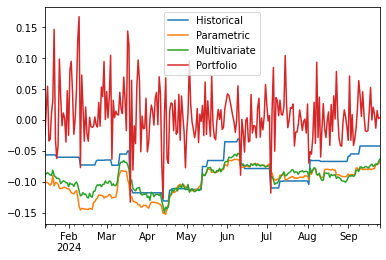

In [76]:
var_data.plot()

<AxesSubplot:>

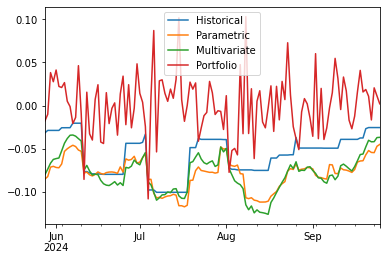

In [77]:
current_var_data.plot()

In [78]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.019531,0.011719,0.011719
Kupiec Stat,6.44746,11.284704,11.284704
P-value,0.011111,0.000781,0.000781


In [79]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.057851,0.024793,0.024793
Kupiec Stat,0.149799,1.971544,1.971544
P-value,0.698727,0.160284,0.160284


## Principal Component Analysis

### Historical PCA

In [80]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.79015979, 0.06588185, 0.05380905, 0.04580205, 0.04434727])

In [81]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.013957
ADAUSDT     0.014263
ALGOUSDT    0.015740
APTUSDT     0.015133
ARBUSDT     0.015266
              ...   
WLDUSDT     0.021483
XECUSDT     0.015224
XLMUSDT     0.009519
XRPUSDT     0.009126
XTZUSDT     0.014314
Name: PC1, Length: 65, dtype: float64

<AxesSubplot:>

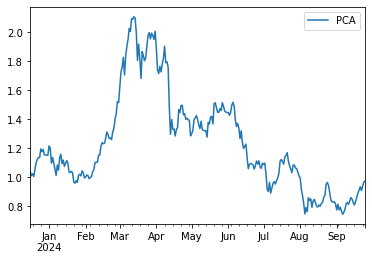

In [82]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

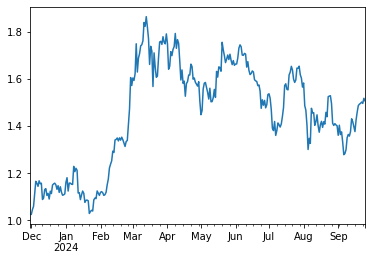

In [83]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [84]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
SANDUSDT     0.308762
XTZUSDT      0.334552
ADAUSDT      0.336728
ALGOUSDT     0.347036
               ...   
PEPEUSDT     0.993329
FLOKIUSDT    1.004498
WLDUSDT      1.034131
CKBUSDT      1.150466
OMUSDT       1.312667
Length: 66, dtype: float64

<AxesSubplot:>

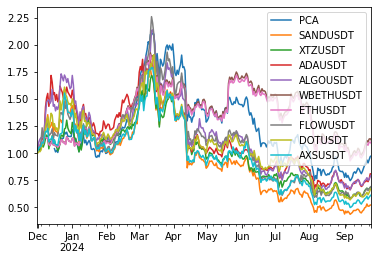

In [85]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

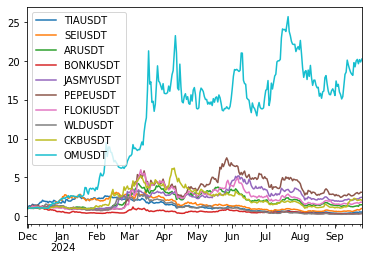

In [86]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [87]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66796311, 0.14044095, 0.08814082, 0.07124566, 0.03220946])

In [88]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.063939
OMUSDT       0.100665
JASMYUSDT    0.154881
SOLUSDT      0.103759
ETHUSDT      0.086725
TRXUSDT      0.014650
BBUSDT       0.245241
BNBUSDT      0.068298
PEPEUSDT     0.161842
Name: PC1, dtype: float64

<AxesSubplot:>

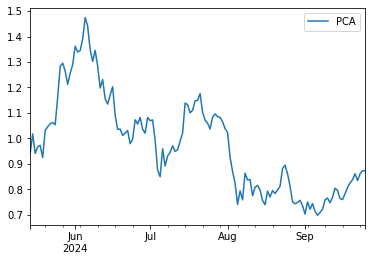

In [89]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

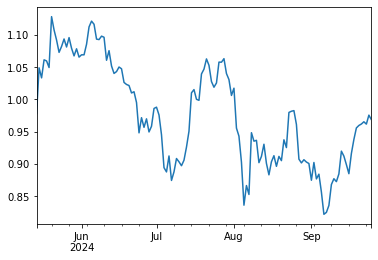

In [90]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [91]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.329014
SOLUSDT      0.343260
BNBUSDT      0.362310
BTCUSDT      0.363688
JASMYUSDT    0.423905
PEPEUSDT     0.457112
OMUSDT       0.534891
TRXUSDT      0.540528
BBUSDT       0.619246
dtype: float64

<AxesSubplot:>

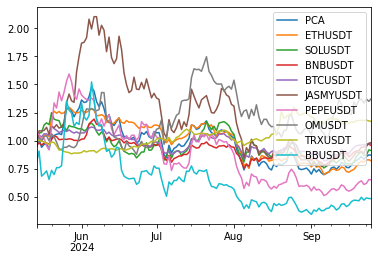

In [92]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [93]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.935627
BBUSDT       1.660316
JASMYUSDT    1.279911
SOLUSDT      1.164182
BTCUSDT      1.000000
OMUSDT       0.988189
ETHUSDT      0.954677
BNBUSDT      0.670868
TRXUSDT      0.278646
Name: BTCUSDT, dtype: float64

In [94]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.560481
BBUSDT       1.525890
JASMYUSDT    1.152339
BTCUSDT      1.000000
SOLUSDT      0.936618
ETHUSDT      0.885999
BNBUSDT      0.607672
OMUSDT       0.194639
TRXUSDT     -0.126378
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [98]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,OMUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.622138,0.000000,0.0,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.000000,0.625881,0.150844,0.000000,0.0,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.000000,0.182521,0.000000,0.000000,0.0,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.414537,0.133222,0.000000,0.111977,0.0,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.0,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.000000,0.435173,0.000000,0.000000,0.0,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.287486,0.000000,0.000000,0.0,0.000000,0.712514,0.000000,0.000000


In [99]:
(rolling_optimization>0.25).sum()

BTCUSDT      1
OMUSDT       3
JASMYUSDT    2
SOLUSDT      0
ETHUSDT      0
TRXUSDT      5
BBUSDT       1
BNBUSDT      0
PEPEUSDT     1
dtype: int64

In [100]:
pd.read_excel('PnL Binance.xlsx')

,Date,Daily PnL,Cumulative Pnl,%
0,2024-09-19,30.09,-376.42,-0.1597
1,2024-09-18,47.27,-406.51,-0.1725
2,2024-09-17,31.29,-453.78,-0.1926
3,2024-09-16,-17.31,-485.07,-0.2059
4,2024-09-15,-36.52,-467.76,-0.1985
...,...,...,...,...
131,2024-05-11,2.89,0.82,0.0023
132,2024-05-10,-3.56,-2.07,-0.0059
133,2024-05-09,2.43,1.49,0.0107
134,2024-05-08,-1.62,-0.94,-0.0134
